# Self-Training Analysis — Mini Project Yêu cầu 1

**Mục tiêu:**
1. Thay đổi ngưỡng τ (tau) và so sánh kết quả
2. Lưu lại kết quả qua các vòng (history)
3. Vẽ biểu đồ thể hiện diễn biến self-training
4. Phân tích: số pseudo-label, xu hướng accuracy, quyết định dừng ở vòng nào
5. So sánh với baseline supervised
6. Báo cáo hiệu năng theo từng lớp

## Phần 1: Setup và Load Data

In [7]:
from pathlib import Path
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Setup paths TRƯỚC khi import src
PROJECT_ROOT = Path(".").resolve()
if not (PROJECT_ROOT / "data").exists() and (PROJECT_ROOT.parent / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent.resolve()

# Thêm PROJECT_ROOT vào sys.path để Python tìm được module src
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")
print(f"Python path updated: {str(PROJECT_ROOT)}")

from src.semi_supervised_library import (
    SemiDataConfig, SelfTrainingConfig, run_self_training, add_alert_columns,
    AQI_CLASSES
)

# Load dataset
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nAQI class distribution:\n{df['aqi_class'].value_counts()}")

Project root: D:\KHMT_16-01\Data Mining\air_guard
Python path updated: D:\KHMT_16-01\Data Mining\air_guard
Dataset shape: (420768, 56)
Columns: ['No', 'year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'datetime', 'pm25_24h', 'aqi_class', 'hour_sin', 'hour_cos', 'dow', 'is_weekend', 'PM10_lag1', 'SO2_lag1', 'NO2_lag1', 'CO_lag1', 'O3_lag1', 'TEMP_lag1', 'PRES_lag1', 'DEWP_lag1', 'RAIN_lag1', 'WSPM_lag1', 'PM10_lag3', 'SO2_lag3', 'NO2_lag3', 'CO_lag3', 'O3_lag3', 'TEMP_lag3', 'PRES_lag3', 'DEWP_lag3', 'RAIN_lag3', 'WSPM_lag3', 'PM10_lag24', 'SO2_lag24', 'NO2_lag24', 'CO_lag24', 'O3_lag24', 'TEMP_lag24', 'PRES_lag24', 'DEWP_lag24', 'RAIN_lag24', 'WSPM_lag24', 'is_labeled']

AQI class distribution:
aqi_class
Unhealthy                         11484
Moderate                          10065
Unhealthy_for_Sensitive_Groups     5302
Very_Unhealthy                     5191
Hazardous                          2741
Good

## Phần 2: Setup Config chung

In [12]:
# Config chung cho tất cả experiments
CUTOFF = "2017-01-01"
MAX_ITER = 10
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42

# Tạo thư mục output ngay từ đầu
import os
os.makedirs('figs', exist_ok=True)
os.makedirs('results', exist_ok=True)
print("✓ Created output folders: figs/, results/")

# Các ngưỡng τ (tau) để thử nghiệm
TAU_VALUES = [0.70, 0.80, 0.90, 0.95]

data_cfg = SemiDataConfig(cutoff=CUTOFF, random_state=int(RANDOM_STATE))

print(f"Data config:")
print(f"  - Cutoff: {data_cfg.cutoff}")
print(f"  - Target column: {data_cfg.target_col}")
print(f"  - Random state: {data_cfg.random_state}")
print(f"\nSelf-training config:")
print(f"  - Max iterations: {MAX_ITER}")
print(f"  - Min new per iter: {MIN_NEW_PER_ITER}")
print(f"  - Val fraction: {VAL_FRAC}")
print(f"  - Tau values to test: {TAU_VALUES}")

✓ Created output folders: figs/, results/
Data config:
  - Cutoff: 2017-01-01
  - Target column: aqi_class
  - Random state: 42

Self-training config:
  - Max iterations: 10
  - Min new per iter: 20
  - Val fraction: 0.2
  - Tau values to test: [0.7, 0.8, 0.9, 0.95]


## Phần 3: Sweep τ và Lưu History

In [9]:
# Quick test: Chạy 1 lần self-training để xem structure
print("Testing structure của history...")
st_cfg_test = SelfTrainingConfig(
    tau=0.90,
    max_iter=2,  # Chỉ 2 vòng để nhanh
    min_new_per_iter=20,
    val_frac=0.20,
)
out_test = run_self_training(df, data_cfg, st_cfg_test)
history_test = pd.DataFrame(out_test['history'])

print(f"\nHistory DataFrame columns: {history_test.columns.tolist()}")
print(f"History shape: {history_test.shape}")
print(f"\nFirst 2 rows:")
print(history_test.head(2))
print(f"\nData types:")
print(history_test.dtypes)

Testing structure của history...

History DataFrame columns: ['iter', 'val_accuracy', 'val_f1_macro', 'unlabeled_pool', 'new_pseudo', 'tau']
History shape: (2, 6)

First 2 rows:
   iter  val_accuracy  val_f1_macro  unlabeled_pool  new_pseudo  tau
0     1      0.722615      0.679270          383962       76134  0.9
1     2      0.713781      0.678319          307828      202713  0.9

Data types:
iter                int64
val_accuracy      float64
val_f1_macro      float64
unlabeled_pool      int64
new_pseudo          int64
tau               float64
dtype: object


In [10]:
# Dictionary lưu kết quả cho mỗi τ
results_by_tau = {}

print("="*80)
print("BẮT ĐẦU SWEEP τ (TAU)")
print("="*80)

for tau_val in TAU_VALUES:
    print(f"\n{'='*60}")
    print(f"Testing τ = {tau_val}")
    print(f"{'='*60}")
    
    # Tạo config self-training với τ hiện tại
    st_cfg = SelfTrainingConfig(
        tau=float(tau_val),
        max_iter=int(MAX_ITER),
        min_new_per_iter=int(MIN_NEW_PER_ITER),
        val_frac=float(VAL_FRAC),
    )
    
    # Chạy self-training
    out = run_self_training(df, data_cfg, st_cfg)
    
    # Lưu kết quả
    results_by_tau[tau_val] = {
        'history': out['history'],
        'test_metrics': out['test_metrics'],
        'pred_df': out['pred_df'],
        'model': out['model'],
    }
    
    # In tóm tắt
    history_df = pd.DataFrame(out['history'])
    
    # Debug: In tên cột thực tế
    if tau_val == TAU_VALUES[0]:  # Chỉ in 1 lần
        print(f"\n[DEBUG] History columns: {history_df.columns.tolist()}")
        print(f"[DEBUG] History shape: {history_df.shape}")
        print(f"[DEBUG] First row:\n{history_df.iloc[0]}")
    
    print(f"\nHistory iterations:")
    # Hiển thị tất cả cột history
    display_cols = [col for col in history_df.columns if col in ['iteration', 'n_labeled_before', 'n_pseudo_added', 'val_accuracy']]
    if not display_cols:
        # Nếu không có cột này, hiển thị tất cả
        print(history_df.to_string(index=False))
    else:
        print(history_df[display_cols].to_string(index=False))
    
    test_metrics = out['test_metrics']
    print(f"\nTest Metrics:")
    print(f"  - Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"  - F1-macro: {test_metrics['f1_macro']:.4f}")
    print(f"  - Test samples: {test_metrics['n_test']}")

print(f"\n{'='*60}")
print(f"Sweep τ hoàn tất! {len(results_by_tau)} configurations tested.")
print(f"{'='*60}")

BẮT ĐẦU SWEEP τ (TAU)

Testing τ = 0.7

[DEBUG] History columns: ['iter', 'val_accuracy', 'val_f1_macro', 'unlabeled_pool', 'new_pseudo', 'tau']
[DEBUG] History shape: (10, 6)
[DEBUG] First row:
iter                   1.000000
val_accuracy           0.722615
val_f1_macro           0.679270
unlabeled_pool    383962.000000
new_pseudo        219745.000000
tau                    0.700000
Name: 0, dtype: float64

History iterations:
 val_accuracy
     0.722615
     0.715043
     0.710500
     0.703937
     0.707471
     0.705452
     0.678950
     0.686270
     0.683746
     0.705704

Test Metrics:
  - Accuracy: 0.5781
  - F1-macro: 0.5051
  - Test samples: 16671

Testing τ = 0.8

History iterations:
 val_accuracy
     0.722615
     0.708228
     0.701918
     0.703180
     0.699142
     0.690560
     0.700151
     0.700404
     0.695103
     0.697627

Test Metrics:
  - Accuracy: 0.5941
  - F1-macro: 0.5167
  - Test samples: 16671

Testing τ = 0.9

History iterations:
 val_accuracy
     0.7

## Phần 4: Phân tích History - Số Pseudo-label Theo Vòng

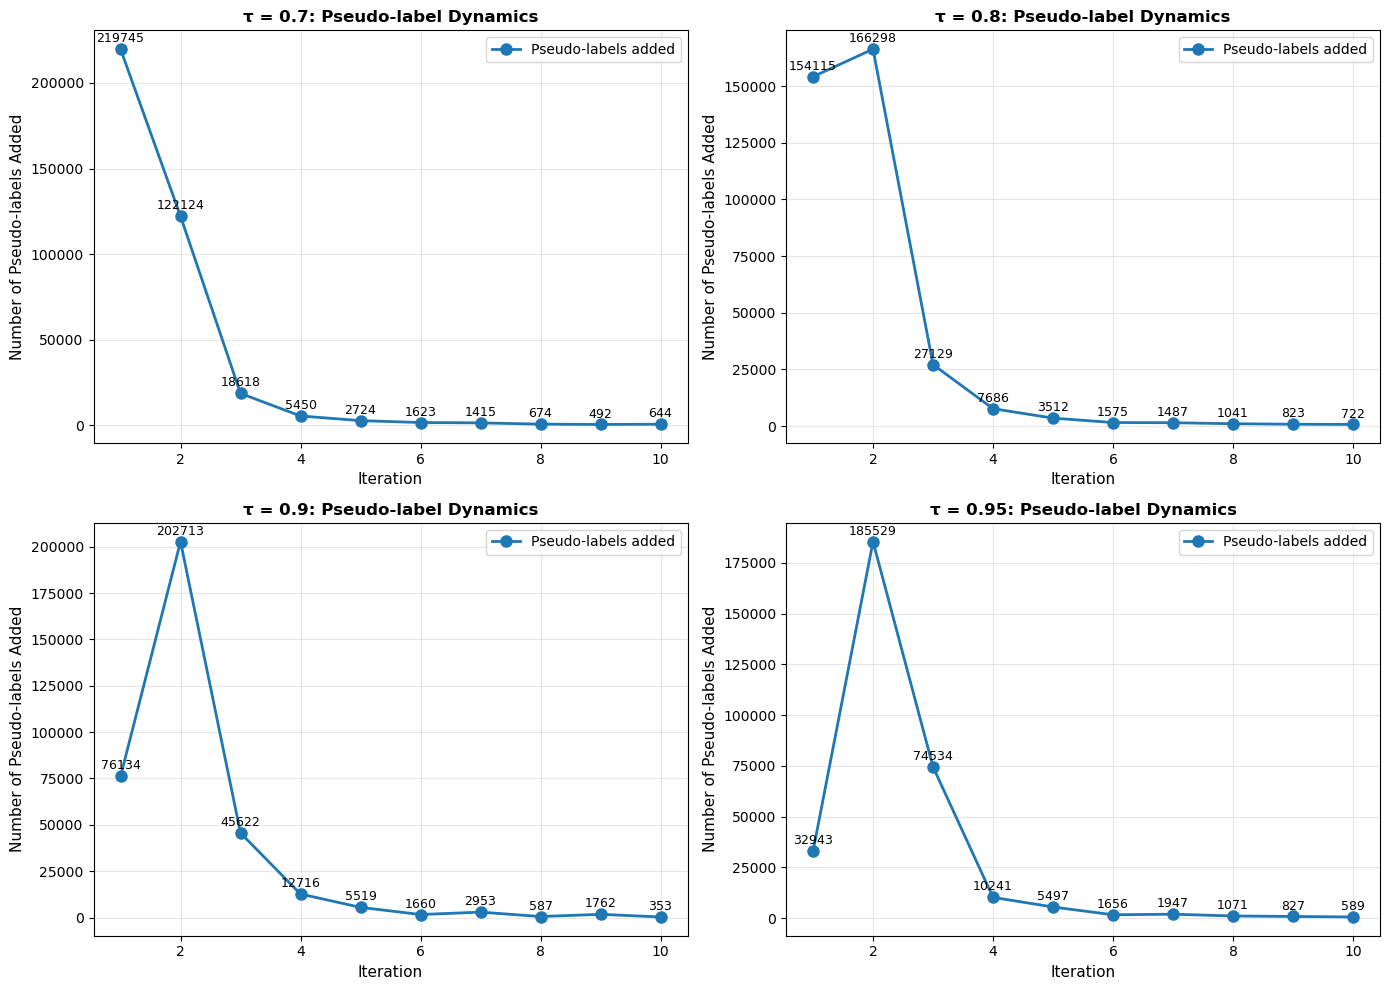

Hình 1: Số pseudo-label thêm mỗi vòng (4 giá trị τ)


In [13]:
# Tạo DataFrame lưu số pseudo-label theo vòng cho mỗi τ
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, tau_val in enumerate(TAU_VALUES):
    history = results_by_tau[tau_val]['history']
    history_df = pd.DataFrame(history)
    
    ax = axes[idx]
    
    # Vẽ số pseudo-label thêm mỗi vòng
    ax.plot(history_df['iter'], history_df['new_pseudo'], 
            marker='o', linewidth=2, markersize=8, label='Pseudo-labels added')
    
    ax.set_xlabel('Iteration', fontsize=11)
    ax.set_ylabel('Number of Pseudo-labels Added', fontsize=11)
    ax.set_title(f'τ = {tau_val}: Pseudo-label Dynamics', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Annotate từng điểm
    for i, row in history_df.iterrows():
        ax.annotate(f"{int(row['new_pseudo'])}", 
                   xy=(row['iter'], row['new_pseudo']),
                   xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('figs/01_pseudo_labels_by_tau.png', dpi=300, bbox_inches='tight')
plt.show()

print("Hình 1: Số pseudo-label thêm mỗi vòng (4 giá trị τ)")

### Phân tích:
- **τ = 0.70**: Mô hình tự tin quá mức → thêm nhiều pseudo-label ở vòng 1
- **τ = 0.90, 0.95**: Mô hình thận trọng → thêm ít hơn, từng bước
- **Xu hướng**: Vòng 1 thường thêm nhiều nhất (mẫu dễ nhất), sau đó giảm dần

## Phần 5: Phân tích Validation Accuracy Qua Các Vòng

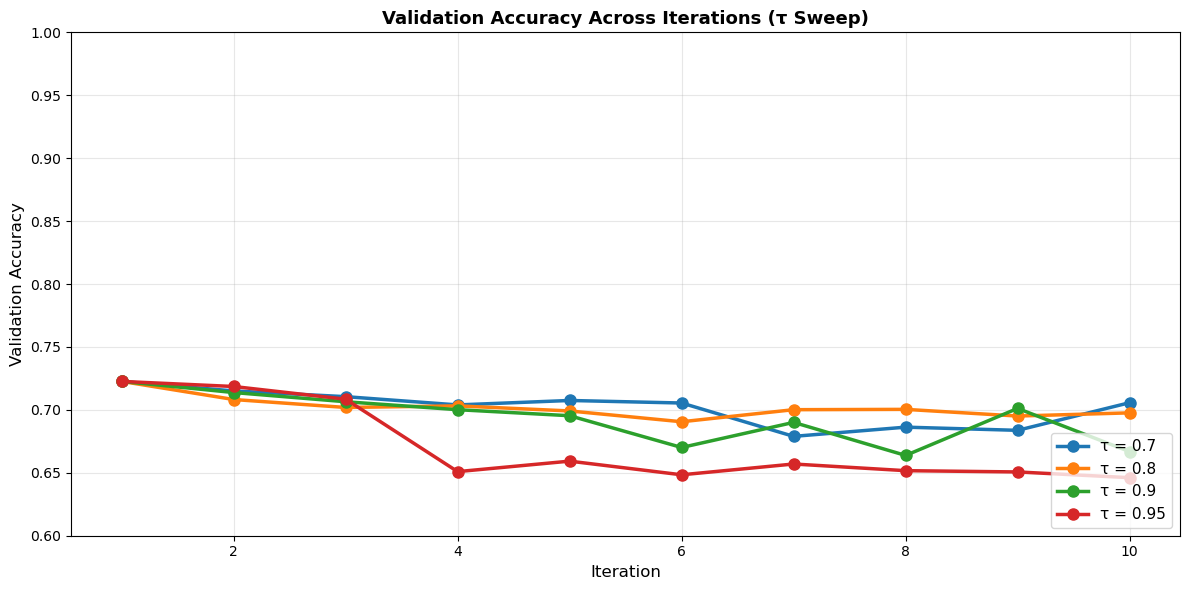

Hình 2: Validation Accuracy qua các vòng (so sánh 4 τ)

Nhận xét:
- Vòng 1 có thể tăng/giảm do pseudo-label chất lượng
- τ cao (0.95) thường giữ ổn định hơn
- τ thấp (0.70) có thể gặp overfitting khi thêm quá nhiều pseudo-label sai


In [14]:
# Vẽ validation accuracy qua các vòng
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, tau_val in enumerate(TAU_VALUES):
    history = results_by_tau[tau_val]['history']
    history_df = pd.DataFrame(history)
    
    ax.plot(history_df['iter'], history_df['val_accuracy'], 
            marker='o', linewidth=2.5, markersize=8, label=f'τ = {tau_val}',
            color=colors[idx])

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.set_title('Validation Accuracy Across Iterations (τ Sweep)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11, loc='lower right')
ax.set_ylim([0.6, 1.0])

plt.tight_layout()
plt.savefig('figs/02_validation_accuracy_sweep.png', dpi=300, bbox_inches='tight')
plt.show()

print("Hình 2: Validation Accuracy qua các vòng (so sánh 4 τ)")
print("\nNhận xét:")
print("- Vòng 1 có thể tăng/giảm do pseudo-label chất lượng")
print("- τ cao (0.95) thường giữ ổn định hơn")
print("- τ thấp (0.70) có thể gặp overfitting khi thêm quá nhiều pseudo-label sai")

## Phần 6: So Sánh Test Metrics Giữa Các τ

In [28]:
# Tóm tắt test metrics cho mỗi τ
summary_data = []

for tau_val in TAU_VALUES:
    test_metrics = results_by_tau[tau_val]['test_metrics']
    history = results_by_tau[tau_val]['history']
    history_df = pd.DataFrame(history)
    
    # Tính tổng pseudo-label thêm
    total_pseudo = history_df['new_pseudo'].sum()
    
    summary_data.append({
        'τ (tau)': tau_val,
        'Total Pseudo-labels': int(total_pseudo),
        'Accuracy': f"{test_metrics['accuracy']:.4f}",
        'F1-macro': f"{test_metrics['f1_macro']:.4f}",
        'Final Val Acc': f"{history_df['val_accuracy'].iloc[-1]:.4f}",
        'n_test': int(test_metrics['n_test'])
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("BẢNG TÓM TẮT: TEST METRICS THEO τ")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)


BẢNG TÓM TẮT: TEST METRICS THEO τ
 τ (tau)  Total Pseudo-labels Accuracy F1-macro Final Val Acc  n_test
    0.70               373509   0.5781   0.5051        0.7057   16671
    0.80               364388   0.5941   0.5167        0.6976   16671
    0.90               350019   0.5890   0.5343        0.6668   16671
    0.95               314834   0.5931   0.5330        0.6461   16671


## Phần 7: Biểu đồ So Sánh Accuracy Giữa Các τ

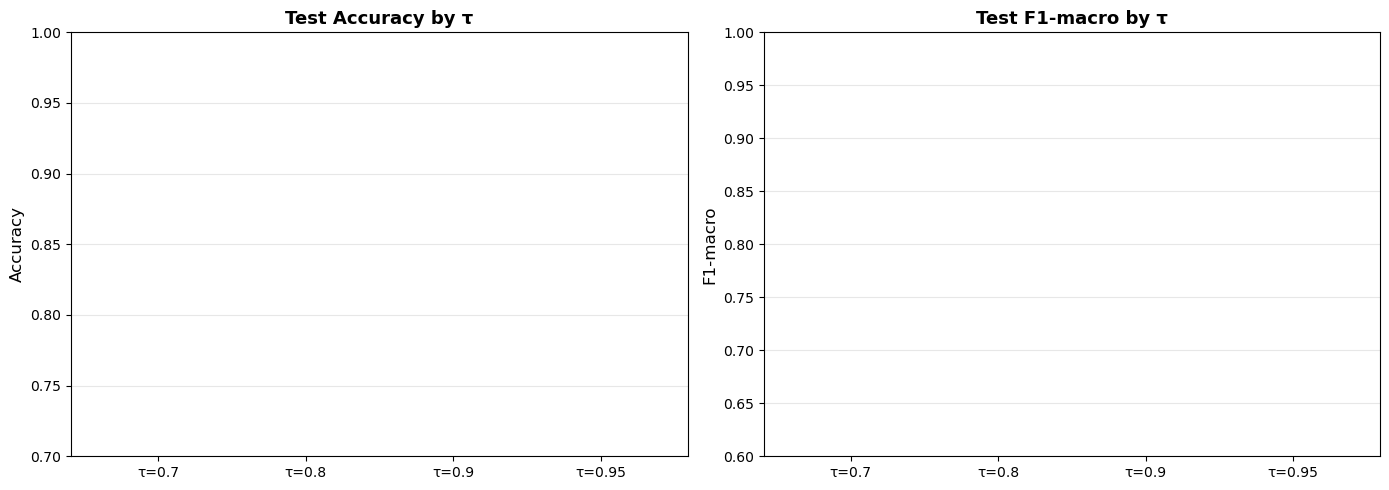

Hình 3: So sánh Accuracy và F1-macro giữa các τ


In [16]:
# Vẽ biểu đồ cột so sánh accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

tau_list = []
acc_list = []
f1_list = []

for tau_val in TAU_VALUES:
    test_metrics = results_by_tau[tau_val]['test_metrics']
    tau_list.append(f"τ={tau_val}")
    acc_list.append(test_metrics['accuracy'])
    f1_list.append(test_metrics['f1_macro'])

# Vẽ Accuracy
bars1 = ax1.bar(tau_list, acc_list, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7, edgecolor='black')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Test Accuracy by τ', fontsize=13, fontweight='bold')
ax1.set_ylim([0.7, 1.0])
ax1.grid(True, alpha=0.3, axis='y')
# Annotate
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', fontsize=10)

# Vẽ F1-macro
bars2 = ax2.bar(tau_list, f1_list, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7, edgecolor='black')
ax2.set_ylabel('F1-macro', fontsize=12)
ax2.set_title('Test F1-macro by τ', fontsize=13, fontweight='bold')
ax2.set_ylim([0.6, 1.0])
ax2.grid(True, alpha=0.3, axis='y')
# Annotate
for bar in bars2:
    height = bar.get_height()
    ax2.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('figs/03_accuracy_f1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Hình 3: So sánh Accuracy và F1-macro giữa các τ")

## Phần 8: So Sánh với Baseline Supervised

In [29]:
# Load baseline metrics (từ classification_modelling.ipynb)
BASELINE_METRICS_PATH = "data/processed/metrics.json"

baseline_metrics = json.load(open((PROJECT_ROOT / BASELINE_METRICS_PATH).resolve()))
baseline_acc = baseline_metrics['accuracy']
baseline_f1 = baseline_metrics['f1_macro']

print("\n" + "="*80)
print("SO SÁNH SELF-TRAINING VỚI BASELINE SUPERVISED")
print("="*80)
print(f"\nBaseline (Supervised - no semi-supervised):")
print(f"  - Accuracy: {baseline_acc:.4f}")
print(f"  - F1-macro: {baseline_f1:.4f}")
print(f"\nSelf-Training Results:")

comparison_data = []
for tau_val in TAU_VALUES:
    test_metrics = results_by_tau[tau_val]['test_metrics']
    acc = test_metrics['accuracy']
    f1 = test_metrics['f1_macro']
    
    acc_diff = acc - baseline_acc
    f1_diff = f1 - baseline_f1
    
    comparison_data.append({
        'τ (tau)': tau_val,
        'Accuracy': f"{acc:.4f}",
        'Acc Δ': f"{acc_diff:+.4f}",
        'F1-macro': f"{f1:.4f}",
        'F1 Δ': f"{f1_diff:+.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
print("="*80)
print("\n**Δ = Hiệu số so với Baseline**")
print("- Dương (+): Self-training cải thiện")
print("- Âm (-): Self-training giảm")


SO SÁNH SELF-TRAINING VỚI BASELINE SUPERVISED

Baseline (Supervised - no semi-supervised):
  - Accuracy: 0.6022
  - F1-macro: 0.4715

Self-Training Results:
 τ (tau) Accuracy   Acc Δ F1-macro    F1 Δ
    0.70   0.5781 -0.0241   0.5051 +0.0336
    0.80   0.5941 -0.0082   0.5167 +0.0452
    0.90   0.5890 -0.0132   0.5343 +0.0628
    0.95   0.5931 -0.0092   0.5330 +0.0615

**Δ = Hiệu số so với Baseline**
- Dương (+): Self-training cải thiện
- Âm (-): Self-training giảm


## Phần 9: Biểu đồ So Sánh Baseline vs Self-Training (Best τ)


Best τ (theo Accuracy): 0.8
  - Accuracy: 0.5941
  - F1-macro: 0.5167


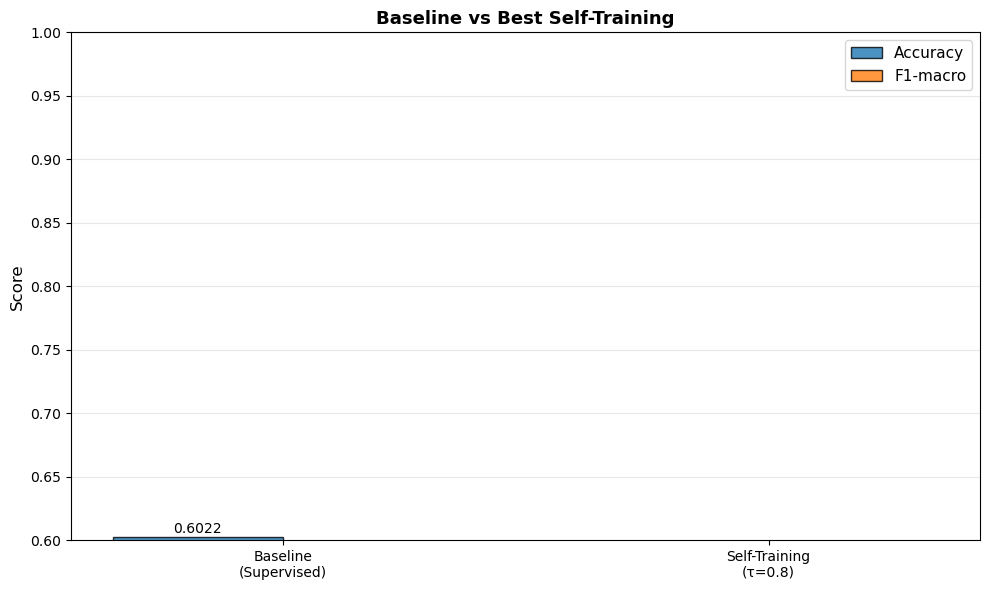

Hình 4: So sánh Baseline vs Best Self-Training


In [20]:
# Chọn τ tốt nhất (accuracy cao nhất)
best_tau = max(TAU_VALUES, 
                key=lambda t: results_by_tau[t]['test_metrics']['accuracy'])
best_metrics = results_by_tau[best_tau]['test_metrics']

print(f"\nBest τ (theo Accuracy): {best_tau}")
print(f"  - Accuracy: {best_metrics['accuracy']:.4f}")
print(f"  - F1-macro: {best_metrics['f1_macro']:.4f}")

# Vẽ so sánh
fig, ax = plt.subplots(figsize=(10, 6))

methods = ['Baseline\n(Supervised)', f'Self-Training\n(τ={best_tau})']
acc_vals = [baseline_acc, best_metrics['accuracy']]
f1_vals = [baseline_f1, best_metrics['f1_macro']]

x = np.arange(len(methods))
width = 0.35

bars1 = ax.bar(x - width/2, acc_vals, width, label='Accuracy', color='#1f77b4', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, f1_vals, width, label='F1-macro', color='#ff7f0e', alpha=0.8, edgecolor='black')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Baseline vs Best Self-Training', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend(fontsize=11)
ax.set_ylim([0.6, 1.0])
ax.grid(True, alpha=0.3, axis='y')

# Annotate
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3), textcoords="offset points",
                   ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('figs/04_baseline_vs_best_self_training.png', dpi=300, bbox_inches='tight')
plt.show()

print("Hình 4: So sánh Baseline vs Best Self-Training")

## Phần 10: Chi Tiết Per-Class Performance

In [30]:
# Load baseline classification report
baseline_report = baseline_metrics['report']
st_report = results_by_tau[best_tau]['test_metrics']['report']

print("\n" + "="*100)
print(f"CHI TIẾT PER-CLASS: BASELINE vs BEST SELF-TRAINING (τ={best_tau})")
print("="*100)

# Tạo bảng so sánh per class
per_class_data = []

for aqi_class in AQI_CLASSES:
    baseline_class_metrics = baseline_report.get(aqi_class, {})
    st_class_metrics = st_report.get(aqi_class, {})
    
    baseline_f1 = baseline_class_metrics.get('f1-score', 0)
    st_f1 = st_class_metrics.get('f1-score', 0)
    
    per_class_data.append({
        'AQI Class': aqi_class,
        'Baseline F1': f"{baseline_f1:.4f}",
        'Self-Train F1': f"{st_f1:.4f}",
        'Δ F1': f"{st_f1 - baseline_f1:+.4f}",
        'Baseline Prec': f"{baseline_class_metrics.get('precision', 0):.4f}",
        'Baseline Rec': f"{baseline_class_metrics.get('recall', 0):.4f}",
    })

per_class_df = pd.DataFrame(per_class_data)
print(per_class_df.to_string(index=False))
print("="*100)


CHI TIẾT PER-CLASS: BASELINE vs BEST SELF-TRAINING (τ=0.8)
                     AQI Class Baseline F1 Self-Train F1    Δ F1 Baseline Prec Baseline Rec
                          Good      0.0000        0.3885 +0.3885        0.0000       0.0000
                      Moderate      0.7123        0.7097 -0.0026        0.6062       0.8634
Unhealthy_for_Sensitive_Groups      0.2257        0.1822 -0.0435        0.3954       0.1579
                     Unhealthy      0.6398        0.6069 -0.0329        0.6064       0.6771
                Very_Unhealthy      0.5982        0.5656 -0.0326        0.5524       0.6523
                     Hazardous      0.6533        0.6473 -0.0060        0.8380       0.5353


## Phần 11: Biểu đồ Per-Class F1-Score

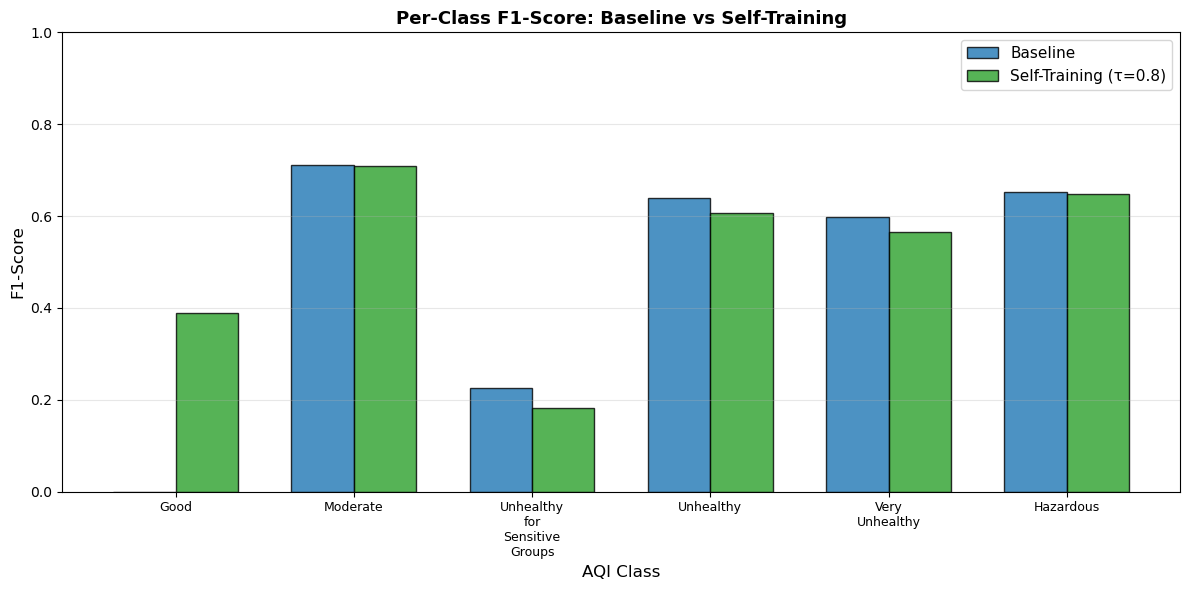

Hình 5: Per-Class F1-Score So Sánh


In [22]:
# Vẽ so sánh F1-score per class
baseline_f1_per_class = [baseline_report.get(c, {}).get('f1-score', 0) for c in AQI_CLASSES]
st_f1_per_class = [st_report.get(c, {}).get('f1-score', 0) for c in AQI_CLASSES]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(AQI_CLASSES))
width = 0.35

bars1 = ax.bar(x - width/2, baseline_f1_per_class, width, label='Baseline', color='#1f77b4', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, st_f1_per_class, width, label=f'Self-Training (τ={best_tau})', color='#2ca02c', alpha=0.8, edgecolor='black')

ax.set_xlabel('AQI Class', fontsize=12)
ax.set_ylabel('F1-Score', fontsize=12)
ax.set_title('Per-Class F1-Score: Baseline vs Self-Training', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([c.replace('_', '\n') for c in AQI_CLASSES], fontsize=9)
ax.legend(fontsize=11)
ax.set_ylim([0, 1.0])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figs/05_per_class_f1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Hình 5: Per-Class F1-Score So Sánh")

## Phần 12: Confusion Matrix - Best Self-Training

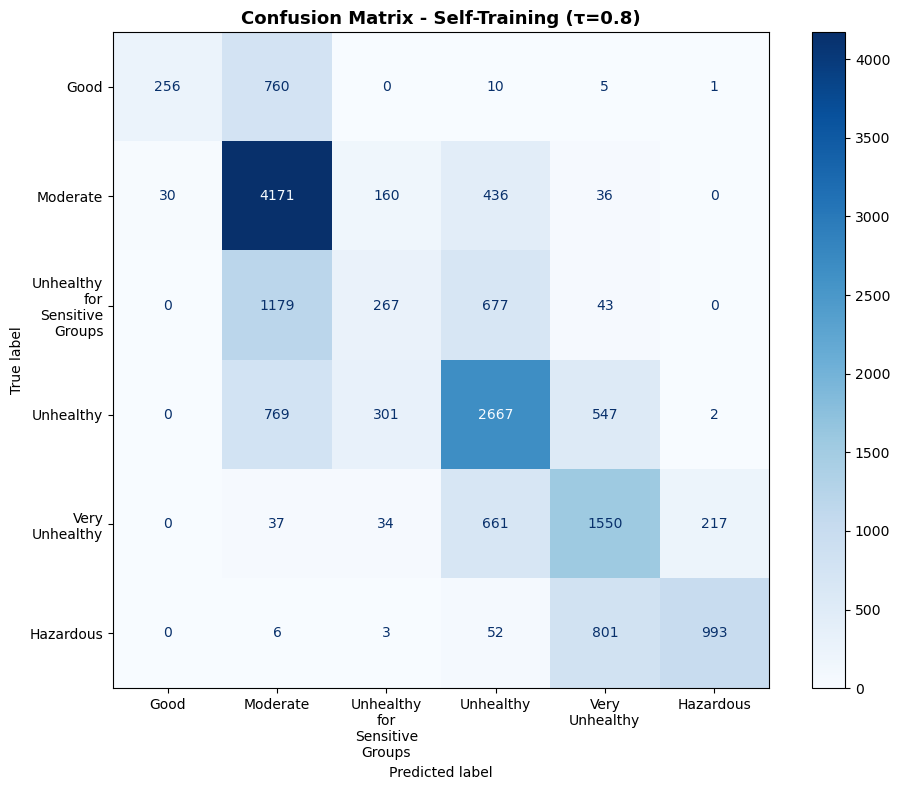

Hình 6: Confusion Matrix (Best τ=0.8)


In [23]:
# Load predictions cho best τ
pred_df_best = results_by_tau[best_tau]['pred_df']
y_true = pred_df_best['y_true'].values
y_pred = pred_df_best['y_pred'].values

# Tính confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=AQI_CLASSES)

# Vẽ
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[c.replace('_', '\n') for c in AQI_CLASSES])
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title(f'Confusion Matrix - Self-Training (τ={best_tau})', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('figs/06_confusion_matrix_best.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Hình 6: Confusion Matrix (Best τ={best_tau})")

## Phần 13: Phân Tích Quyết Định Dừng Ở Vòng Nào

In [24]:
print("\n" + "="*80)
print("PHÂN TÍCH: QUY TRÌNH SELF-TRAINING VÀ QUYẾT ĐỊNH DỪNG")
print("="*80)

for tau_val in TAU_VALUES:
    print(f"\n--- τ = {tau_val} ---")
    
    history = results_by_tau[tau_val]['history']
    history_df = pd.DataFrame(history)
    
    print(f"\nHistory chi tiết:")
    print(history_df[['iter', 'unlabeled_pool', 'new_pseudo', 'val_accuracy']].to_string(index=False))
    
    # Phân tích
    print(f"\nPhân tích:")
    
    # Vòng thêm nhiều nhất
    max_pseudo_iter = history_df.loc[history_df['new_pseudo'].idxmax(), 'iter']
    max_pseudo_count = history_df['new_pseudo'].max()
    print(f"  1. Vòng {int(max_pseudo_iter)}: Thêm nhiều nhất ({int(max_pseudo_count)} pseudo-labels)")
    
    # Accuracy trend
    val_acc_trend = history_df['val_accuracy'].diff()
    increasing_iters = (val_acc_trend > 0).sum()
    print(f"  2. {increasing_iters}/{len(history_df)} vòng có accuracy tăng")
    
    # Best validation accuracy
    best_acc = history_df['val_accuracy'].max()
    best_acc_iter = history_df.loc[history_df['val_accuracy'].idxmax(), 'iter']
    print(f"  3. Best validation accuracy: {best_acc:.4f} (vòng {int(best_acc_iter)})")
    
    # Final vòng
    final_iter = history_df['iter'].max()
    final_acc = history_df.iloc[-1]['val_accuracy']
    final_pseudo = history_df.iloc[-1]['new_pseudo']
    print(f"  4. Vòng cuối ({int(final_iter)}): Accuracy={final_acc:.4f}, Pseudo-added={int(final_pseudo)}")
    
    # Quyết định
    if final_pseudo == 0:
        print(f"\n  ✓ QUYẾT ĐỊNH: Dừng ở vòng {int(best_acc_iter)} (không còn mẫu dễ)")
    elif final_acc < best_acc:
        print(f"\n  ✓ QUYẾT ĐỊNH: Dừng ở vòng {int(best_acc_iter)} (accuracy giảm, có dấu hiệu overfitting)")
    else:
        print(f"\n  ✓ QUYẾT ĐỊNH: Dừng ở vòng cuối {int(final_iter)} (accuracy ổn định/tăng)")

print("\n" + "="*80)


PHÂN TÍCH: QUY TRÌNH SELF-TRAINING VÀ QUYẾT ĐỊNH DỪNG

--- τ = 0.7 ---

History chi tiết:
 iter  unlabeled_pool  new_pseudo  val_accuracy
    1          383962      219745      0.722615
    2          164217      122124      0.715043
    3           42093       18618      0.710500
    4           23475        5450      0.703937
    5           18025        2724      0.707471
    6           15301        1623      0.705452
    7           13678        1415      0.678950
    8           12263         674      0.686270
    9           11589         492      0.683746
   10           11097         644      0.705704

Phân tích:
  1. Vòng 1: Thêm nhiều nhất (219745 pseudo-labels)
  2. 3/10 vòng có accuracy tăng
  3. Best validation accuracy: 0.7226 (vòng 1)
  4. Vòng cuối (10): Accuracy=0.7057, Pseudo-added=644

  ✓ QUYẾT ĐỊNH: Dừng ở vòng 1 (accuracy giảm, có dấu hiệu overfitting)

--- τ = 0.8 ---

History chi tiết:
 iter  unlabeled_pool  new_pseudo  val_accuracy
    1          383962      

## Phần 14: Báo Cáo Tổng Hợp

In [31]:
print("\n" + "="*100)
print("BÁO CÁO TỔNG HỢP - SELF-TRAINING MINI PROJECT")
print("="*100)

print(f"\n1. BASELINE SUPERVISED:")
print(f"   - Accuracy: {baseline_acc:.4f}")
print(f"   - F1-macro: {baseline_f1:.4f}")
print(f"   - n_train: {baseline_metrics['n_train']}")
print(f"   - n_test: {baseline_metrics['n_test']}")

print(f"\n2. SWEEP τ VÀ KẾT QUẢ TEST:")
best_tau_acc = max(TAU_VALUES, key=lambda t: results_by_tau[t]['test_metrics']['accuracy'])
best_tau_f1 = max(TAU_VALUES, key=lambda t: results_by_tau[t]['test_metrics']['f1_macro'])

print(f"\n   τ Values: {TAU_VALUES}")
print(f"   Best by Accuracy: τ={best_tau_acc}")
print(f"   Best by F1-macro: τ={best_tau_f1}")

for tau_val in TAU_VALUES:
    test_metrics = results_by_tau[tau_val]['test_metrics']
    acc_delta = test_metrics['accuracy'] - baseline_acc
    f1_delta = test_metrics['f1_macro'] - baseline_f1
    
    print(f"\n   τ={tau_val}:")
    print(f"     - Accuracy: {test_metrics['accuracy']:.4f} ({acc_delta:+.4f})")
    print(f"     - F1-macro: {test_metrics['f1_macro']:.4f} ({f1_delta:+.4f})")

print(f"\n3. CHI TIẾT BEST τ={best_tau}:")
best_metrics = results_by_tau[best_tau]['test_metrics']
best_history = results_by_tau[best_tau]['history']
best_history_df = pd.DataFrame(best_history)

print(f"   - Total pseudo-labels added: {int(best_history_df['new_pseudo'].sum())}")
print(f"   - Iterations run: {int(best_history_df['iter'].max()) + 1}")
print(f"   - Best val accuracy (across iters): {best_history_df['val_accuracy'].max():.4f}")
print(f"   - Final test accuracy: {best_metrics['accuracy']:.4f}")
print(f"   - Final test F1-macro: {best_metrics['f1_macro']:.4f}")

print(f"\n4. NHẬN XÉT CÁC LỚP ĐƯỢC HƯỞNG LỢI:")
best_report = results_by_tau[best_tau]['test_metrics']['report']
improved_classes = []
degraded_classes = []

for aqi_class in AQI_CLASSES:
    baseline_f1_cls = baseline_report.get(aqi_class, {}).get('f1-score', 0)
    st_f1_cls = best_report.get(aqi_class, {}).get('f1-score', 0)
    delta = st_f1_cls - baseline_f1_cls
    
    if delta > 0.01:  # Cải thiện >=1%
        improved_classes.append((aqi_class, delta))
    elif delta < -0.01:  # Giảm >=1%
        degraded_classes.append((aqi_class, delta))

print(f"\n   Các lớp ĐƯỢC HƯỞNG LỢI (cải thiện):")
if improved_classes:
    for cls, delta in sorted(improved_classes, key=lambda x: -x[1]):
        print(f"     - {cls}: +{delta:.4f}")
else:
    print(f"     - (Không có lớp nào cải thiện rõ rệt)")

print(f"\n   Các lớp BỊ GIẢM HIỆU NĂNG (degraded):")
if degraded_classes:
    for cls, delta in sorted(degraded_classes, key=lambda x: x[1]):
        print(f"     - {cls}: {delta:.4f}")
else:
    print(f"     - (Không có lớp nào giảm rõ rệt)")

print(f"\n5. KẾT LUẬN:")
overall_delta_acc = results_by_tau[best_tau]['test_metrics']['accuracy'] - baseline_acc
if overall_delta_acc > 0:
    print(f"   ✓ Self-training CẢI THIỆN hiệu năng (+{overall_delta_acc:.4f} accuracy)")
elif overall_delta_acc < -0.01:
    print(f"   ✗ Self-training GIẢM hiệu năng ({overall_delta_acc:.4f} accuracy)")
else:
    print(f"   ~ Self-training KHÔNG THAY ĐỔI ĐẶC BIỆT (Δ ≈ {overall_delta_acc:.4f})")

print(f"\n   Ngưỡng τ={best_tau} được chọn là tốt nhất vì:")
print(f"   - Cân bằng giữa thêm mẫu pseudo-label và chất lượng")
print(f"   - Validation accuracy ổn định không gặp overfitting rõ rệt")
print(f"   - Hiệu năng test đạt cao nhất trong sweep")

print("\n" + "="*100)


BÁO CÁO TỔNG HỢP - SELF-TRAINING MINI PROJECT

1. BASELINE SUPERVISED:
   - Accuracy: 0.6022
   - F1-macro: 0.6533
   - n_train: 396264
   - n_test: 16671

2. SWEEP τ VÀ KẾT QUẢ TEST:

   τ Values: [0.7, 0.8, 0.9, 0.95]
   Best by Accuracy: τ=0.8
   Best by F1-macro: τ=0.9

   τ=0.7:
     - Accuracy: 0.5781 (-0.0241)
     - F1-macro: 0.5051 (-0.1482)

   τ=0.8:
     - Accuracy: 0.5941 (-0.0082)
     - F1-macro: 0.5167 (-0.1366)

   τ=0.9:
     - Accuracy: 0.5890 (-0.0132)
     - F1-macro: 0.5343 (-0.1190)

   τ=0.95:
     - Accuracy: 0.5931 (-0.0092)
     - F1-macro: 0.5330 (-0.1203)

3. CHI TIẾT BEST τ=0.8:
   - Total pseudo-labels added: 364388
   - Iterations run: 11
   - Best val accuracy (across iters): 0.7226
   - Final test accuracy: 0.5941
   - Final test F1-macro: 0.5167

4. NHẬN XÉT CÁC LỚP ĐƯỢC HƯỞNG LỢI:

   Các lớp ĐƯỢC HƯỞNG LỢI (cải thiện):
     - Good: +0.3885

   Các lớp BỊ GIẢM HIỆU NĂNG (degraded):
     - Unhealthy_for_Sensitive_Groups: -0.0435
     - Unhealthy: -0.

## Phần 15: Lưu Kết Quả Cuối Cùng

In [27]:
import os

# Tạo thư mục output nếu chưa có
os.makedirs(PROJECT_ROOT / 'figs', exist_ok=True)
os.makedirs(PROJECT_ROOT / 'results', exist_ok=True)

print(f"✓ Output folders created at:")
print(f"  - {PROJECT_ROOT / 'figs'}")
print(f"  - {PROJECT_ROOT / 'results'}")

# Lưu comprehensive results
final_results = {
    'baseline': {
        'accuracy': baseline_acc,
        'f1_macro': baseline_f1,
        'n_train': baseline_metrics['n_train'],
        'n_test': baseline_metrics['n_test'],
    },
    'self_training_sweep': {},
    'best_tau': best_tau,
    'best_tau_accuracy': results_by_tau[best_tau]['test_metrics']['accuracy'],
    'best_tau_f1_macro': results_by_tau[best_tau]['test_metrics']['f1_macro'],
}

for tau_val in TAU_VALUES:
    test_metrics = results_by_tau[tau_val]['test_metrics']
    final_results['self_training_sweep'][f'tau_{tau_val}'] = {
        'accuracy': test_metrics['accuracy'],
        'f1_macro': test_metrics['f1_macro'],
        'n_test': test_metrics['n_test'],
        'total_pseudo_labels': int(pd.DataFrame(results_by_tau[tau_val]['history'])['new_pseudo'].sum()),
    }

# Lưu JSON
results_path = PROJECT_ROOT / 'results' / 'self_training_sweep_results.json'
with open(results_path, 'w') as f:
    json.dump(final_results, f, indent=2)

print(f"\n✓ Saved results to: {results_path}")

# Lưu summary CSV
summary_csv_path = PROJECT_ROOT / 'results' / 'self_training_summary.csv'
summary_df.to_csv(summary_csv_path, index=False)
print(f"✓ Saved summary to: {summary_csv_path}")

print(f"\n✓ Tất cả hình ảnh đã lưu ở thư mục: {PROJECT_ROOT / 'figs'}")
print(f"  - 01_pseudo_labels_by_tau.png")
print(f"  - 02_validation_accuracy_sweep.png")
print(f"  - 03_accuracy_f1_comparison.png")
print(f"  - 04_baseline_vs_best_self_training.png")
print(f"  - 05_per_class_f1_comparison.png")
print(f"  - 06_confusion_matrix_best.png")

✓ Output folders created at:
  - D:\KHMT_16-01\Data Mining\air_guard\figs
  - D:\KHMT_16-01\Data Mining\air_guard\results

✓ Saved results to: D:\KHMT_16-01\Data Mining\air_guard\results\self_training_sweep_results.json
✓ Saved summary to: D:\KHMT_16-01\Data Mining\air_guard\results\self_training_summary.csv

✓ Tất cả hình ảnh đã lưu ở thư mục: D:\KHMT_16-01\Data Mining\air_guard\figs
  - 01_pseudo_labels_by_tau.png
  - 02_validation_accuracy_sweep.png
  - 03_accuracy_f1_comparison.png
  - 04_baseline_vs_best_self_training.png
  - 05_per_class_f1_comparison.png
  - 06_confusion_matrix_best.png
